# MLP autoencoders

An autoencoder is a network that consists of two main parts:
- an *encoder*, which projects the data into a latent space to transform it into a compact representation.
- a *decoder*, which reconstructs the input data from the latent representation.

In mathematical terms, a data point $\mathbf{x} \in \mathbb{R}^N$ is transformed into a latent representation $\mathbf{z} \in \mathbb{R}^L$, where $L \ll N$. Then, the latent representation is passed to the decoder, which produces an approximation $\hat{\mathbf{x}} \in \mathbb{R}^N$ of the input data, i.e., such that $\hat{\mathbf{x}} \approx \mathbf{x}$.

Autoencoders are very useful in many applications. For instance, in image processing, they are used for image denoising, compression, and generative models (image synthesis and transformation). They can also be used for transfer learning: first an autoencoder is trained to learn a latent representation of the data, and then this representation can be used for other classification/regression tasks.

<center><a href="https://emkademy.medium.com/1-first-step-to-generative-deep-learning-with-autoencoders-22bd41e56d18">
    <img src="https://miro.medium.com/max/772/1*ztZn098tDQsnD5J6v1eNuQ.png" width="600"></a></center>


In [30]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
import copy

In [31]:
# Initialization function for the network's parameters
def init_params(m, seed=0):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return

## Dataset

In [32]:
# Dataset repository - remember to change it according to your folder structure
data_dir = '../datasets/'

# Load the MNIST dataset
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
test_data = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=data_transforms)
num_classes = len(train_data.classes)

# Take a subset of the train/test data
train_data = Subset(train_data, torch.arange(500))
test_data = Subset(train_data, torch.arange(50))

# We define the train and validation sets and dataloaders as in the previous script
n_train_examples = int(len(train_data)*0.8)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples], generator=torch.manual_seed(0))

# Create the dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(0))
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [33]:
# Get a batch of images from the train dataloader (no need for the labels here)
image_batch_example = next(iter(train_dataloader))[0]

## The encoder

First, let us write the encoder. We consider a 3-layer encoder, where each layer consists of a Linear part and a ReLU activation function. The first layer goes from size `input_size` to 128, the second layer from 128 to 64, and the third layer from 64 to 32.

In [34]:
# TO DO: write the encoder class ('__init__' and 'forward' methods)

class Encoder(nn.Module):
    def __init__(self, input_size):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )
    def forward(self, x):
        x = self.encoder(x)
        return x
      

In [35]:
# TO DO:
# - instanciate an encoder (get the proper input size)
encoder = Encoder(28*28)
# - vectorize image_batch_example into image_batch_example_vec
image_batch_example_vec = image_batch_example.view(-1, 28*28)
# - apply the encoder to image_batch_example_vec to produce the latent representation 'z'
z = encoder(image_batch_example_vec)
# - print the size of z, and the size of the image_batch_example_vec
print(z.size())


torch.Size([8, 32])


You can see that the latent representation has a significantly smaller dimension than the original data (vectorized image).


## The decoder

The decoder as a similar structure than the encoder (3 {Linear + activation} layers) but the sizes are flipped: the first layer goes from 32 to 64, the second layer goes from 64 to 128, and the last layer goest from 128 back to the input size. The first and second layers use a ReLU activation, but the last layer uses a Sigmoid: this forces the output to be in the range $[0,1]$, which corresponds to the normalized images.

In [36]:
# TO DO: write the decoder class ('__init__' and 'forward' methods)

class Decoder(nn.Module):
    def __init__(self, input_size):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_size),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.decoder(x)
        return x

In [37]:
# TO DO:
# - instanciate a decoder
decoder = Decoder(28*28)
# - apply it to the latent representation z computed before
decoder_output = decoder(z)
# - print the size of the output 'y' of the decoder : it should be the same as the input data 'image_batch_example_vec'
decoder_output.size()

torch.Size([8, 784])

## The autoencoder main module

Finally we can write the autoencoder module. It simply consists of an encoder and a decoder applied sequentially.

<span style="color:red">**Exercice 3**</span> Write the MLP autoencoder class. Instanciate an MLP autoencoder, initialize its parameters, and print the number of parameters.

In [38]:
class Autoencoder(nn.Module):
  def __init__(self, encoder, decoder):
    super(Autoencoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    
  def forward(self, x):
    z = self.encoder(x)
    y = self.decoder(z)
    return y
    
autoencoder = Autoencoder(encoder, decoder)
output = autoencoder(image_batch_example_vec)
print(output.size())

torch.Size([8, 784])


## Training

Now we can write the training function (with validation !). It's very similar to the training function for the MLP classifier from the previous script, up to three main differences:
- Since we don't try to predict a label, we don't need to load them when iterating over the dataloader.
- The loss function is no longer Cross Entropy (which is for classification), but [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html?highlight=mse#torch.nn.MSELoss) (*cf.* lab 2).
- For validation, unlike for classification, we monitor the MSE loss (instead of the accuracy), thus it should be decreasing (instead of increasing).

Regarding the loss, remember that the autoencoder tries to compress the input data $\mathbf{x}$ (through the encoder) and then produce an approximation $\hat{\mathbf{x}}$ of this input data (through the decoder). This means that the input and output of the decoder should have the same dimension, and the loss is computed between these two quantities: $\mathcal{L}(\hat{\mathbf{x}}, \mathbf{x})$.

<span style="color:red">**Exercice 4**</span> Write the autoencoder training function with validation (you also need to write the evaluation function). Train the autoencoder (30 epochs, learning rate=0.001, and MSE loss function), and plot the training and validation losses over epochs.

In [39]:
# Evaluation function
def evaluate_autoencoder(autoencoder, dataloader, criterion):
    autoencoder.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs in dataloader:
            inputs = inputs[0].view(-1, 28*28)
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
    return running_loss / len(dataloader)

In [40]:
# Training function
def train_autoencoder(autoencoder, train_dataloader, valid_dataloader, criterion, optimizer, num_epochs):
    best_model_wts = copy.deepcopy(autoencoder.state_dict())
    best_loss = float('inf')
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        autoencoder.train()
        running_loss = 0.0
        for inputs in train_dataloader:
            inputs = inputs[0].view(-1, 28*28)
            optimizer.zero_grad()
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_train_loss = running_loss / len(train_dataloader)
        epoch_valid_loss = evaluate_autoencoder(autoencoder, valid_dataloader, criterion)
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        if epoch_valid_loss < best_loss:
            best_loss = epoch_valid_loss
            best_model_wts = copy.deepcopy(autoencoder.state_dict())
        print(f'Epoch {epoch+1}/{num_epochs} : Train Loss = {epoch_train_loss:.4f} - Valid Loss = {epoch_valid_loss:.4f}')
    autoencoder.load_state_dict(best_model_wts)
    return autoencoder, train_losses, valid_losses

Epoch 1/30 : Train Loss = 0.8976 - Valid Loss = 0.8407


Epoch 2/30 : Train Loss = 0.7820 - Valid Loss = 0.8184
Epoch 3/30 : Train Loss = 0.7423 - Valid Loss = 0.7625
Epoch 4/30 : Train Loss = 0.7114 - Valid Loss = 0.7497
Epoch 5/30 : Train Loss = 0.6904 - Valid Loss = 0.7323
Epoch 6/30 : Train Loss = 0.6721 - Valid Loss = 0.7158
Epoch 7/30 : Train Loss = 0.6545 - Valid Loss = 0.7029
Epoch 8/30 : Train Loss = 0.6422 - Valid Loss = 0.6987
Epoch 9/30 : Train Loss = 0.6319 - Valid Loss = 0.6869
Epoch 10/30 : Train Loss = 0.6246 - Valid Loss = 0.6837
Epoch 11/30 : Train Loss = 0.6184 - Valid Loss = 0.6813
Epoch 12/30 : Train Loss = 0.6135 - Valid Loss = 0.6776
Epoch 13/30 : Train Loss = 0.6083 - Valid Loss = 0.6751
Epoch 14/30 : Train Loss = 0.6047 - Valid Loss = 0.6725
Epoch 15/30 : Train Loss = 0.6001 - Valid Loss = 0.6708
Epoch 16/30 : Train Loss = 0.5982 - Valid Loss = 0.6675
Epoch 17/30 : Train Loss = 0.5950 - Valid Loss = 0.6672
Epoch 18/30 : Train Loss = 0.5926 - Valid Loss = 0.6671
Epoch 19/30 : Train Loss = 0.5904 - Valid Loss = 0.6719


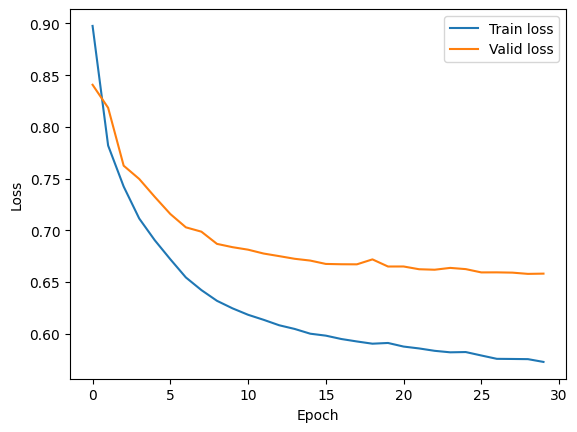

In [41]:
num_epochs = 30
learning_rate = 0.001
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

autoencoder, train_losses, valid_losses = train_autoencoder(autoencoder, train_dataloader, valid_dataloader, loss_fn, optimizer, num_epochs)

# Plot the training and validation losses

plt.plot(train_losses, label='Train loss')
plt.plot(valid_losses, label='Valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



## Visualization

Once the autoencoder is trained, we can use it to reconstruct an input image.

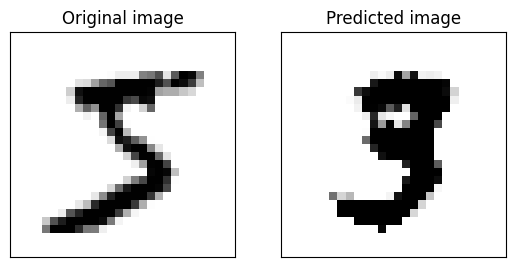

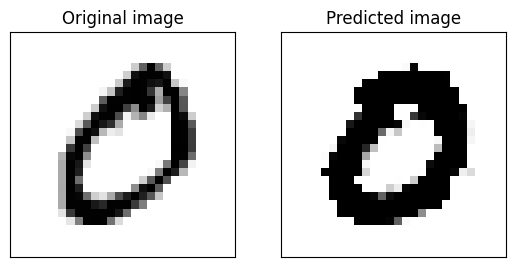

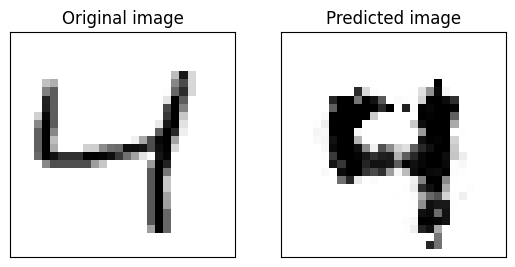

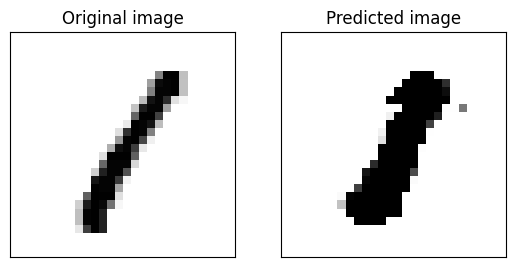

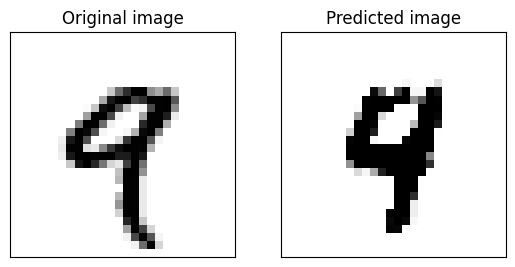

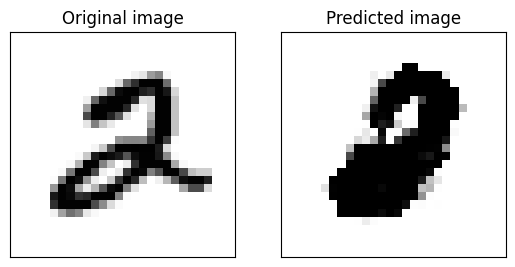

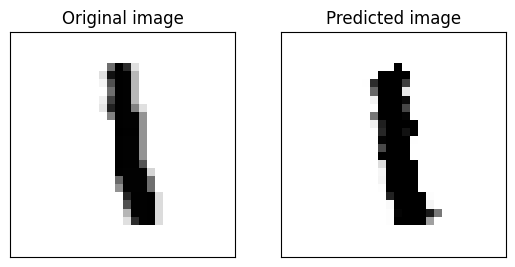

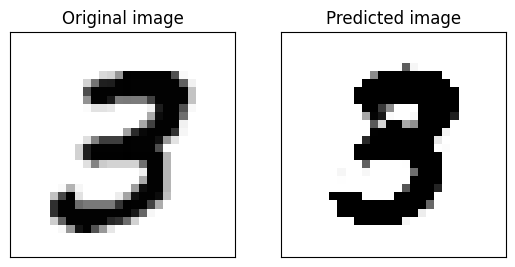

In [42]:
# Get a sample from the test dataloader
test_batch = next(iter(test_dataloader))[0]
bsize = test_batch.shape[0]

# Vectorize and apply the model
test_batch_vec = test_batch.reshape(bsize, -1)
with torch.no_grad():
    test_batch_vec_pred = autoencoder(test_batch_vec)

# Reshape the prediction as a black-and-white image (3D tensor)
test_batch_pred = test_batch_vec_pred.reshape(bsize, 1, 28, 28)

# Plot the original and predicted images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(test_batch[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(test_batch_pred[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Predicted image')
    plt.show()